In [1]:
import pandas as pd
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import warnings
warnings.filterwarnings("ignore")

import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.model_selection import GroupKFold
from typing import Any
import xgboost as xgb
from sklearn import metrics
from itertools import product
import copy
import time


In [3]:
%%time
train = pd.read_csv('2019_Data_Science_Bowl/data/train.csv')
train_label = pd.read_csv('2019_Data_Science_Bowl/data/train_labels.csv')
test = pd.read_csv('2019_Data_Science_Bowl/data/test.csv')
specs = pd.read_csv('2019_Data_Science_Bowl/data/specs.csv')
sample_submission = pd.read_csv('2019_Data_Science_Bowl/data/sample_submission.csv')

CPU times: user 54.8 s, sys: 8.33 s, total: 1min 3s
Wall time: 1min 3s


In [13]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [14]:
train.shape

(11341042, 11)

In [4]:
keep_id = train[train.type == 'Assessment'][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on='installation_id')
train.shape

(8294138, 11)

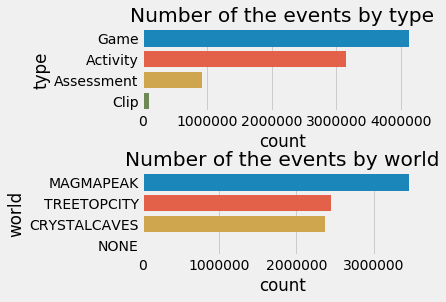

CPU times: user 4.35 s, sys: 4.87 s, total: 9.22 s
Wall time: 9.09 s


In [5]:
%%time
# Visualize the exist columns
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y='type', data=train, order=train.type.value_counts().index)
plt.title("Number of the events by type")

ax2 = fig.add_subplot(212)
ax2= sns.countplot(y='world', data=train, order=train.world.value_counts().index)
plt.title("Number of the events by world")
plt.tight_layout(pad=0)
plt.show()

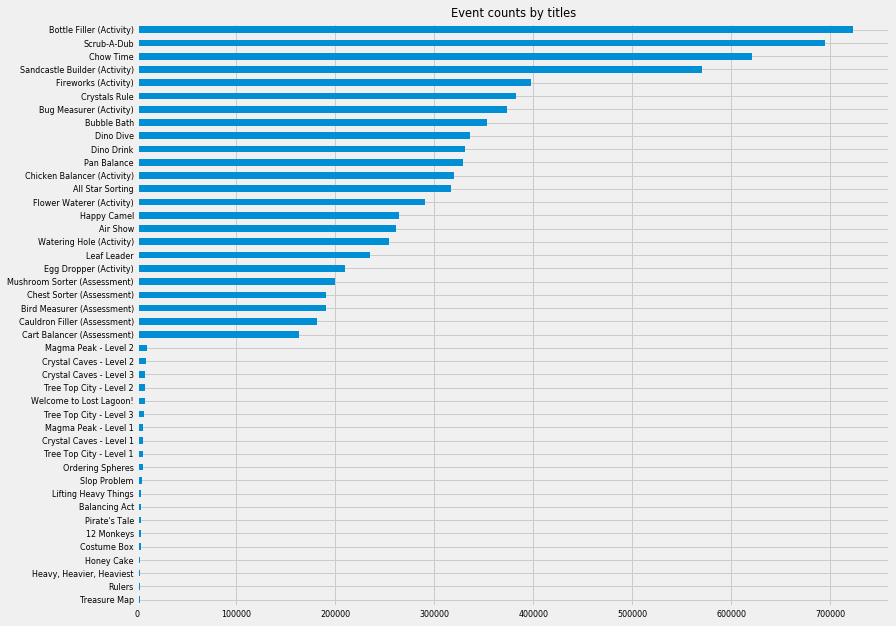

CPU times: user 2.01 s, sys: 96 ms, total: 2.11 s
Wall time: 2.1 s


In [6]:
%%time
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(12, 10))
se = train.title.value_counts().sort_values(ascending=True)
se.plot.barh()
plt.title("Event counts by titles")
plt.show()

In [7]:
# add some new columns based on the timestamp and visualize these.
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df

train = get_time(train)

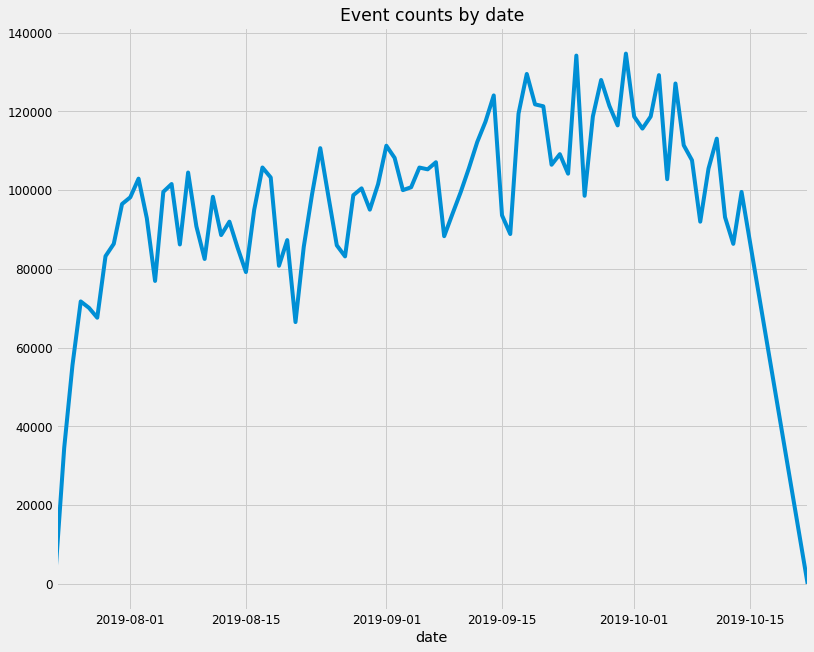

In [8]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(12,10))
se = train.groupby('date')['date'].count()
se.plot()
plt.title("Event counts by date")
plt.show()

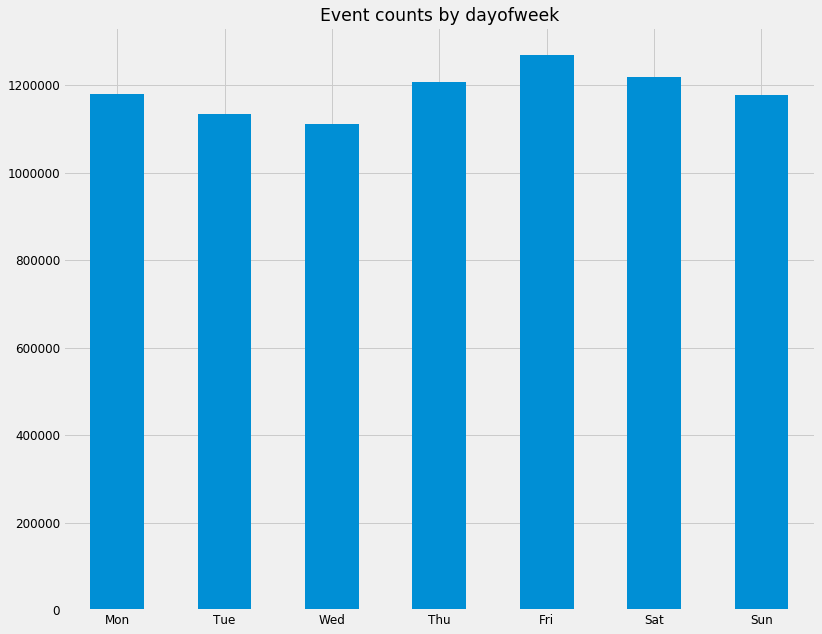

In [9]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('dayofweek')['dayofweek'].count()
se.index = list(calendar.day_abbr)
se.plot.bar()
plt.title("Event counts by dayofweek")
plt.xticks(rotation=0)
plt.show()

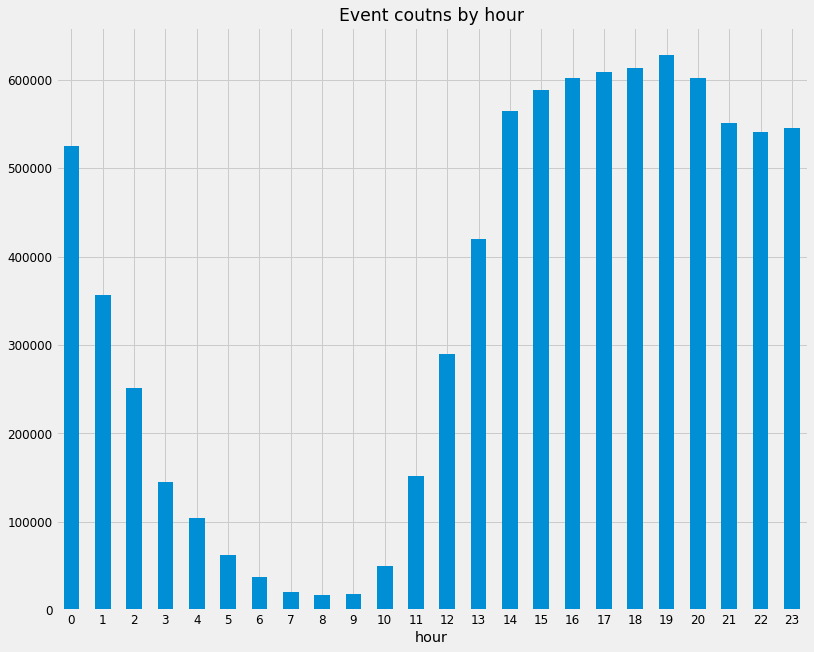

In [10]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('hour')['hour'].count()
se.plot.bar()
plt.xticks(rotation=0)
plt.title('Event coutns by hour')
plt.show()

In [11]:
pd.options.display.max_rows = 50
train[train.installation_id=='0006a69f'].drop(['event_id'], axis=1)

,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
0,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,8,4,1
1,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,8,4,1
2,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
3,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
4,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,0721802df0531701,2019-08-29 16:33:53.227000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,11,3010,23145,Dino Dive,Game,MAGMAPEAK,2019-08-29,8,16,3
3797,0721802df0531701,2019-08-29 16:33:56.880000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,12,3110,26804,Dino Dive,Game,MAGMAPEAK,2019-08-29,8,16,3
3798,0721802df0531701,2019-08-29 16:34:11.881000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,13,3010,41805,Dino Dive,Game,MAGMAPEAK,2019-08-29,8,16,3
3799,0721802df0531701,2019-08-29 16:34:15.480000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,14,3110,45405,Dino Dive,Game,MAGMAPEAK,2019-08-29,8,16,3


In [15]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [17]:
test[(test.installation_id=='00abaee7') & (test.type=='Assessment')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
282,7ad3efc6,8b38fc0d2fd315dc,2019-09-11T18:56:11.918Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
283,65a38bf7,8b38fc0d2fd315dc,2019-09-11T18:56:12.019Z,"{""crystals"":[{""id"":""gem07"",""weight"":6},{""id"":""...",00abaee7,2,2020,58,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
284,795e4a37,8b38fc0d2fd315dc,2019-09-11T18:56:12.030Z,"{""description"":""We've got to balance this scal...",00abaee7,3,3010,58,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
285,5e109ec3,8b38fc0d2fd315dc,2019-09-11T18:56:15.790Z,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",00abaee7,4,4030,3852,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
286,5c2f29ca,8b38fc0d2fd315dc,2019-09-11T18:56:17.869Z,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",00abaee7,5,4020,5968,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
287,828e68f9,8b38fc0d2fd315dc,2019-09-11T18:56:19.084Z,"{""description"":""We've got to balance this scal...",00abaee7,6,3110,7185,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
288,5e109ec3,8b38fc0d2fd315dc,2019-09-11T18:56:19.155Z,"{""crystal_id"":""gem08"",""weight"":6,""coordinates""...",00abaee7,7,4030,7218,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
289,5c2f29ca,8b38fc0d2fd315dc,2019-09-11T18:56:19.783Z,"{""crystal_id"":""gem08"",""weight"":6,""coordinates""...",00abaee7,8,4020,7885,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
290,acf5c23f,8b38fc0d2fd315dc,2019-09-11T18:56:23.168Z,"{""coordinates"":{""x"":842,""y"":654,""stage_width"":...",00abaee7,9,4070,11252,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
291,acf5c23f,8b38fc0d2fd315dc,2019-09-11T18:56:23.184Z,"{""coordinates"":{""x"":267,""y"":609,""stage_width"":...",00abaee7,10,4070,11252,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
